# Основы глубинного обучения, майнор ИАД

# Выполнил Родин Владимир

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 01.10.2023

Мягкий дедлайн: 23:59MSK 15.10.2023

Жесткий дедлайн: 23:59MSK 20.10.2023

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Итогова оценка считается как
$$
min(task_1, task_2)*0.8 + max(task_1, task_2)*0.2
$$

где task_1 и task_2 - оценки за первое и второе заданиее соответсвенно.
Также, за домашнее задание выставляется 0, если не сделано нулевое или третье задание.
### О задании

В этом задании вам предстоит предсказывать год выпуска песни (**задача регрессии**) по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [5]:
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
device = "cuda" if torch.cuda.is_available() else "cpu"
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv('YearPredictionMSD.txt', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


Мы вывели кусок данных, чтобы понять, насколько они пригодны для работы без изменений. Здесь ясно, что сомнительно дальше с такими данными работать, потому что как минимум есть отрицательные значения, которые не отмасштабированы, кроме того еще сразу бросается в глаза совсем разная размерность, где-то видим реально большие числа, а где-то 0.075. Ясно, что будем скейлить.

In [7]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

Для выполнения данного задания (и всех последующих) предобработайте данные.

1. Зафиксируйте random_seed везде где только возможно. Вам предоставлена функция для этого, однако вы можете дополнить ее своими дополнениями
2. Обучите StandertScaler и предобработайте ваши данные. В следующих заданиях можете использовать другой scaler или вообще отказаться от него


In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [9]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [10]:
set_random_seed(42)

In [11]:
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

def rmse(y_test, y_pred):
  return np.power(mean_squared_error(y_test, y_pred), 0.5)

alpha_optimal = 0
rmse_optimal = 400
alphas = {}
for alpha in range(1, 51):
  model = Ridge(alpha=alpha)
  model.fit(X_train_scaled, y_train)
  y_pred = model.predict(X_test_scaled)
  alphas[alpha] = rmse(y_test, y_pred)
  if alphas[alpha] < rmse_optimal:
    alpha_optimal = alpha  # наилучшая альфа
    rmse_optimal = alphas[alpha]  # ее лучше значение rmse
alphas

{1: 9.510160820470436,
 2: 9.51016093357472,
 3: 9.510161046801464,
 4: 9.510161160150654,
 5: 9.510161273622279,
 6: 9.510161387216328,
 7: 9.510161500932787,
 8: 9.510161614771647,
 9: 9.510161728732893,
 10: 9.510161842816514,
 11: 9.510161957022499,
 12: 9.510162071350834,
 13: 9.510162185801507,
 14: 9.510162300374507,
 15: 9.510162415069823,
 16: 9.510162529887443,
 17: 9.510162644827352,
 18: 9.51016275988954,
 19: 9.510162875073995,
 20: 9.510162990380705,
 21: 9.51016310580966,
 22: 9.510163221360841,
 23: 9.510163337034244,
 24: 9.510163452829854,
 25: 9.51016356874766,
 26: 9.510163684787646,
 27: 9.510163800949805,
 28: 9.510163917234122,
 29: 9.510164033640587,
 30: 9.510164150169185,
 31: 9.510164266819906,
 32: 9.51016438359274,
 33: 9.51016450048767,
 34: 9.510164617504689,
 35: 9.510164734643782,
 36: 9.510164851904939,
 37: 9.510164969288148,
 38: 9.510165086793394,
 39: 9.510165204420666,
 40: 9.510165322169955,
 41: 9.510165440041249,
 42: 9.510165558034531,
 43: 9.

При разных значениях альфы RMSE меняется, но не так сильно. Альфа выберу просто ту, где минимальное RMSE.

In [13]:
rmse_for_model = rmse_optimal
rmse_for_model

9.510160820470436

Лучшая константа для RMSE это среднее, посчитаем значение метрики при нем

In [14]:
y_train_mean = np.mean(y_train) * np.ones((len(y_test)))  
# делают вектор среднего, который размерность совпадает с тестовым вектором
best_rmse_metric = rmse(y_train_mean, y_test)
best_rmse_metric

10.85246390513634

## Задание 1. (максимум 10 баллов)

Закрепите свои знания о том, как pytorch работает с обратным распространением ошибки, проделав следующие шаги:

1. Создайте модель линейной регрессии, которая будет состоять только из одного Linear слоя.
2. Напишите цикл обучения вашей линейной регрессии. В нем реализуйте подсчет функции потерь, сделайте шаг градиентного спуска. Запрещено использовать готовые оптимизаторы и loss-функции из библиотеки pytorch. Для подсчета градиента воспользуйтесь методом backward.
3. Запустите обучение на 10 эпохах, после каждой проверяйте значение целевой метрики на тестовой выборке.
4. Выведите на экран графики метрики и значения функции потерь на тестовой и обучающей выборке.

В данном задании нет цели побить какой-то порог по метрике. Ваша задача - убедиться в том, что ваш рукописный цикл обучения работает. Для ускорения вычислений и обучения модели можете брать только срез данных, а не весь датасет.

In [15]:
g_step = 0.05  # коэффициент просто подобрал
train_losses = {i: 0 for i in range(1, 11)}
test_losses = {}
coeffs = torch.ones((91, 1), requires_grad=True).double()  # инициализирую вектор весов
coeffs.retain_grad()

x_tst = torch.tensor(X_test_scaled[:25000], requires_grad=True)  # возьму из тестовой и обучающей выборок по 10к наблюдений
y_tst = torch.tensor(y_test[:25000])

for epochs in range(1, 11):
    for i in range(0, 10000 - 128, 128):  # возьму batchsize равный 128
        x = torch.tensor(X_train_scaled[i: i + 128, :], requires_grad=True)
        y = torch.tensor(y_train[i: i + 128])
        prediction = x @ coeffs[1:] + coeffs[0]
        loss = torch.mean((prediction - y) ** 2)  # функция потерь
        loss.backward()
        coeffs -= g_step * coeffs.grad  # делаю шаг градиента
        coeffs.grad.zero_()
        train_losses[epochs] += loss.item() ** 0.5  # запоминаю rmse для построения графика по обучающей выборке
    train_losses[epochs] /= 10000 / 128
    
    with torch.no_grad():
        prediction_test = x_tst @ coeffs[1:] + coeffs[0]  # прогноз по тестовой выборке
        test_losses[epochs] = (float(torch.mean((prediction_test - y_tst) ** 2))) ** 0.5 
    # запоминаю rmse для построения графика по тестовой выборке

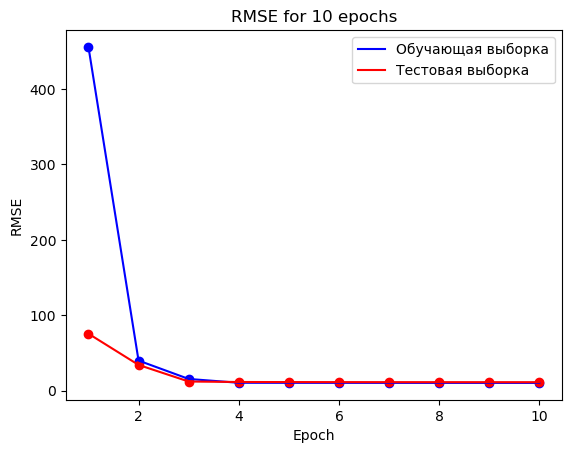

In [16]:
plt.plot(list(train_losses.keys()), list(train_losses.values(),), c='blue', label='Обучающая выборка')
plt.plot(list(test_losses.keys()), list(test_losses.values()), c='red', label='Тестовая выборка')
plt.scatter(list(train_losses.keys()), list(train_losses.values(),), c='blue')
plt.scatter(list(test_losses.keys()), list(test_losses.values()), c='red')
plt.legend()
plt.title('RMSE for 10 epochs')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.show()

Цель достигнута: я смог выстроить уменьшение RMSE по мере возростания количества эпох. Однако начиная с 3 эпохи, коэффициент падает все медленнее, если вообще падает. А также заметна почти равномерная разница между обучающей и тестовой выборкой. Это проблема может быть решена путем ```перемешивания наблюдений при обучении```. Кроме того, я оставил постоянным коэффициент при градиенте. Его ```динамическое уменьшение``` может так же повысить качество модели. Кроме того, я использую весьма наивную первичную инициализацию весов. Возможно стоит взять ```другие начальные веса```. Рассмотрим график начиная с 4 эпохи в приближении.

In [17]:
for i in range(1, 4):
    del train_losses[i]
    del test_losses[i]

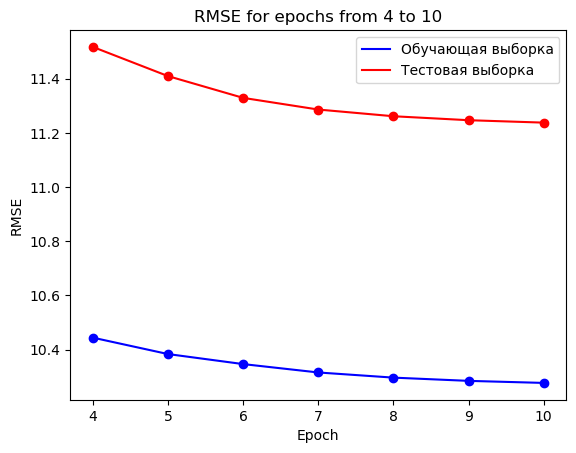

In [18]:
plt.plot(list(train_losses.keys()), list(train_losses.values(),), c='blue', label='Обучающая выборка')
plt.plot(list(test_losses.keys()), list(test_losses.values()), c='red', label='Тестовая выборка')
plt.scatter(list(train_losses.keys()), list(train_losses.values(),), c='blue')
plt.scatter(list(test_losses.keys()), list(test_losses.values()), c='red')
plt.legend()
plt.title('RMSE for epochs from 4 to 10')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.show()

Значение RMSE убывает, и разница RMSE обучающих и тестовых данных непостоянна. 

## Задание 2. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Не забудьте, что для улучшения качества модели вам поможет **нормировка таргета**.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из предыдущего задания.



Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться сигнатурами функций, которые приведены ниже. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

In [19]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

In [20]:
scaler_x, scaler_y = StandardScaler(), StandardScaler()
X_train = scaler_x.fit_transform(X_train)  
X_test = scaler_x.transform(X_test)
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1))

y_train = torch.tensor(y_train[:int(len(X_test) * 0.3)])  #буду работать с 30% данных. Нормирую таргет
y_test = torch.tensor(y_test[:int(len(X_test) * 0.3)])
X_train = torch.tensor(X_train[:int(len(X_test) * 0.3)])
X_test = torch.tensor(X_test[:int(len(X_test) * 0.3)])

In [21]:
class RandomDataset(torch.utils.data.Dataset): # как написал выше, хочу перемешать обучающую выборку. Взял с первого семинара

    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return {
            "sample": self.x[idx, :],
            "target": self.y[idx],
        }

    
train_set = RandomDataset(X_train, y_train)
test_set = RandomDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_set, shuffle = True, batch_size=32)
test_loader = torch.utils.data.DataLoader(test_set, shuffle = False, batch_size=32)

In [22]:
class MyModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(90, 128),
            nn.ReLU(),
            nn.Linear(128, 90), 
            nn.ReLU(),
            nn.Linear(90, 128), 
            nn.ReLU(),
            nn.Linear(128, 90), 
            nn.ReLU(),
            nn.Linear(90, 1)
            )
        
    def forward(self, X):
        return self.model(X)


In [23]:
number_of_epochs = 4
learning_rate = 0.01 # значение просто взял с семинара

model = MyModel()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0)

criterion = nn.MSELoss()

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.90) 
# значение для гаммы взял с https://gist.github.com/Mahedi-61/7e3a88230cc8123bcdb9072aef0d062c
#Там просто какой-то код, но я искал изначальной какой-нибудь оптимизатор для scheduler.

In [24]:
def train(model, optimizer, criterion, train_loader, test_loader):
    train_losses, test_losses = {i: 0 for i in range(1, number_of_epochs + 1)}, {i: 0 for i in range(1, number_of_epochs + 1)} 
    
    for epoch in range(1, number_of_epochs + 1):
        
        model.train()
        for batch in tqdm(train_loader):
            x_train = batch['sample']
            y_train = batch['target']
            y_pred = model(x_train.float())
            loss = criterion(y_pred, y_train.float())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            with torch.no_grad():
                predict_inverse = torch.tensor(scaler_y.inverse_transform(y_pred.reshape(-1, 1))) 
                # таргет перевожу обратно от нормировки
                y_train_inverse = torch.tensor(scaler_y.inverse_transform(y_train.reshape(-1, 1)))
                loss = criterion(y_train_inverse, predict_inverse)
                train_losses[epoch] += loss.item() ** 0.5
        
        scheduler.step()
        
        model.eval()                    
        with torch.no_grad():
            for batch in tqdm(test_loader):
                x_test = batch['sample']
                y_test = batch['target']
                y_pred = model(x_test.float())
                loss = criterion(torch.tensor(scaler_y.inverse_transform(y_pred.float())), torch.unsqueeze(y_test, 1))
                test_losses[epoch] += loss.item() ** 0.5
        
        train_losses[epoch] /= len(train_loader)
        test_losses[epoch] /= len(test_loader)

    plt.plot(list(train_losses.keys()), list(train_losses.values(),), c='blue', label='Обучающая выборка')
    plt.plot(list(test_losses.keys()), list(test_losses.values()), c='red', label='Тестовая выборка')
    plt.scatter(list(train_losses.keys()), list(train_losses.values(),), c='blue')
    plt.scatter(list(test_losses.keys()), list(test_losses.values()), c='red')
    plt.legend()
    plt.title('RMSE for epochs')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.show()
    print(test_losses)

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

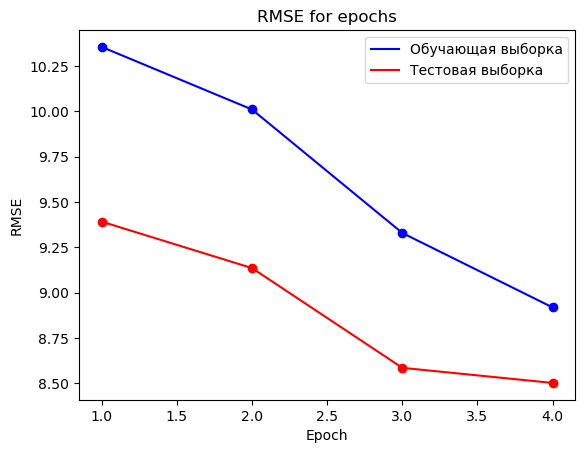

{1: 9.391790217638352, 2: 9.135376349479232, 3: 8.584601291922521, 4: 8.501320179883898}


In [25]:
train(model, optimizer, criterion, train_loader, test_loader)

Итоговое значение RMSE для тестовой выборки у меня составило 8.5 по 30% тестовой выборки.

## Задание 3. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

Мне показалась эта домашняя работа сложной :( 

Во-первых, поговорим про саму архитектуру нейронной сети. Для одного ленейного слоя из задания 1 я смог максимум выбить 9.15. Думал использовать эту схему, но реализуя алгоритм через класс, я встретился с проблемой: RMSE почему-то оказывался запредельно высоким. Я стал подбирать разные другие архитектуры. Решил попробывать сделать с следующей форме, которая как бы расширяется к центру:

In [26]:
class MyModel2(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(90, 128),
            nn.ReLU(),
            nn.Linear(128, 90),
            nn.ReLU(),
            nn.Linear(90, 1),
            )
        
    def forward(self, X):
        return self.model(X)


  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

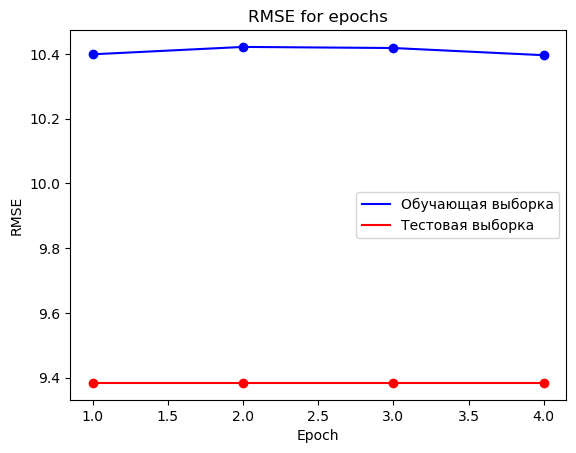

{1: 9.383364264423594, 2: 9.383364264423594, 3: 9.383364264423594, 4: 9.383364264423594}


In [27]:
model = MyModel2()
train(model, optimizer, criterion, train_loader, test_loader)

Не работает. Я попробывал сделать еще разные другие формы, нормальный результат вышел только на той, которая представлена в MyModel.

Количество эпох. Та архитектура нейронной сети на которой я остановился стала очень быстро переобучаться ( при количестве эпох больше 10). Например при 20 эпохах:

In [29]:
number_of_epochs = 20
learning_rate = 0.01 

model = MyModel()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0)

criterion = nn.MSELoss()

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.90) 

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

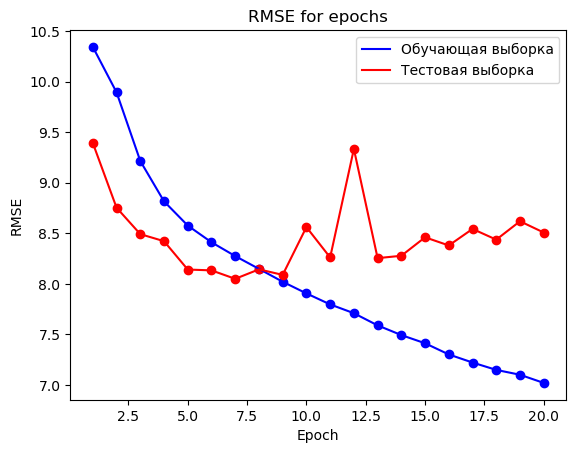

{1: 9.392342912422562, 2: 8.752785199724347, 3: 8.491145445119427, 4: 8.4214627637954, 5: 8.141045760958844, 6: 8.132720735304522, 7: 8.049225894088554, 8: 8.142745401024921, 9: 8.088178682938407, 10: 8.560844916704932, 11: 8.260602612809125, 12: 9.333649604733617, 13: 8.253770134786972, 14: 8.27715430655091, 15: 8.459916175072337, 16: 8.379218262803033, 17: 8.542711677442586, 18: 8.436687139579425, 19: 8.618607630527688, 20: 8.507052485831213}


In [30]:
train(model, optimizer, criterion, train_loader, test_loader)

Методом пристольного взгляда я понимаю, что эффективнее всего модель учится приблизительно до 4-6 эпохи. Теперь я хочу попробовать взять другой оптимизатор.

In [31]:
number_of_epochs = 4
learning_rate = 0.01 # значение просто взял с семинара

model = MyModel()

optimizer = torch.optim.ASGD(model.parameters(), lr=learning_rate)

criterion = nn.MSELoss()

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.90) 


  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

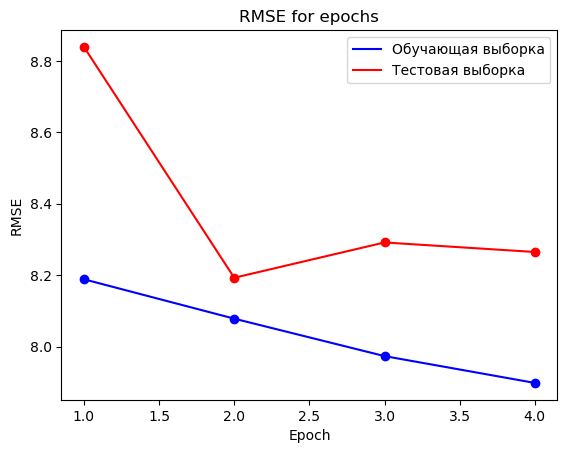

{1: 8.838825228172935, 2: 8.193008813050097, 3: 8.291796242014556, 4: 8.265122723738827}


In [34]:
train(model, optimizer, criterion, train_loader, test_loader)

Можно заметить, что модель начинает очень рано переобучаться. Однако это заметно не всегда. Принципиального различия оптимизаторов в рамках имеющейся у меня модели обнаружено не было.